# Dynamic Programming for reservoir operations vs. Non-Linear Programming

## Part a

Consider a three-season reservoir operation problem. Assume the inflows are always 10, 50 and 30 in seasons 1, 2 and 3, respectively. Your goal is to minimize the sum of total squared deviations above and below a constant storage target of 20 and above and below a constant release target of 20 in each of the three seasons.

Using nonlinear programming with the BFGS algorithm in scipy.minimize.optimize, find the optimal release in each season. Use bounds of [0,40] for releases and [0,30] for storage.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

######################## NLP Optimization ########################

# inflows and targets
Qs = np.array([10, 50, 30])
Stargets = np.ones([len(Qs)])*20
Rtargets = np.ones([len(Qs)])*20

def calcSquaredDeviation(x):
    # convert decision variables to state variables
    R = x[0:3]
    S = x[3::]

    # calculate squared differences between actual values and targets
    # Stargets and Rtargets do not need to be passed to this function as they
    # are defined as global variables before it
    S_deviation = np.sum((S-Stargets)**2)
    R_deviation = np.sum((R-Rtargets)**2)
    Cost = S_deviation + R_deviation

    return Cost

constraints = ({'type': 'eq', 'fun': lambda x: x[4] - x[3] - Qs[0] + x[0]}, # mass balance t=0->1
        {'type': 'eq', 'fun': lambda x: x[5] - x[4] - Qs[1] + x[1]}, # mass balance t=1->2
        {'type': 'eq', 'fun': lambda x: x[3] - x[5] - Qs[2] + x[2]}) # mass balance t=2->3, t3=t0


# R is between 0 and 40, S is positive and can't exceed capacity K=30
bounds = np.concatenate(([[10,40]]*3, [[0,30]]*3),0).tolist()

# initialize guesses at R = R_target and S = S_target for all stages
x0 = np.concatenate((Rtargets,Stargets),0)

# optimization with BFGS
result = minimize(calcSquaredDeviation, x0, bounds=bounds, constraints=constraints)
print("Optimal releases each season: ", result.x[0:3]) # first three are optimal releases, next three are optimal storages


Optimal releases each season:  [25. 35. 30.]


## Part b

Using Python, write a discrete dynamic program to find the operating policy. Consider 7 discrete storage values: 0, 5, 10, 15, 20, 25, and 30. Assume the releases cannot be less than 10 or greater than 40. Report your results as a table showing the optimal release in each of the three seasons for each of the seven storage levels.

In [3]:
######################## DP Optimization ########################

def calcCost(S, Q, Starget, Rtarget, bounds, FutureCost):
    '''
    Function to calculate the optimal release (Rbest) from each storage state (S)
    and associated present and future cost (Cbest), defined as the total squared
    deviation between storage and release targets for that stage.

    Inputs:
      S: array of discrete storage values representing the states
      Q: inflow received at this stage
      Starget: target storage for next stage
      Rtarget: release target for this stage
      bounds: bounds on possible releases
      FutureCost: array of future costs at each state that will be added to
      cost of the optimal state transition at this stage to compute present + future cost

    Outputs:
      Rbest: array of optimal releases from each state in S
      Cbest: array of present + future costs associated with each state S
    '''

    # initialize current cost at infinity and releases at 0
    Cbest = np.empty([len(S)])+np.inf
    Rbest = np.zeros([len(S)])
    for i, s in enumerate(S): # storage at stage t
        # find optimal storage to move to at stage t+1
        for j, sNext in enumerate(S): # storage at stage t+1
            R = s + Q - sNext # release to get to sNext
            # find cost of this release if it's feasible
            if R >= bounds[0] and R <= bounds[1]:
                # compute total cost C (total deviation from targets + future cost at sNext)
                S_deviation = (sNext-Starget)**2
                R_deviation = (R-Rtarget)**2
                C = S_deviation + R_deviation + FutureCost[j]
                # update optimal value (Cbest) and decision (Rbest) if better than current best
                if C < Cbest[i]:
                    Cbest[i] = C
                    Rbest[i] = R

    return Rbest, Cbest

# get indices of stages
nStages = len(Qs)
forward_indices = np.arange(nStages)
backward_indices = forward_indices[::-1] # reverse order of stages for backward-moving DP
backward_indices = np.insert(backward_indices,0,0) # put 0 at beginning to make it cyclic

# discretize states
states = np.arange(0,31,5)
nStates = len(states)

# bounds on decision variables (releases)
bounds = np.array([10, 40])

# initialize matrices with costs of each state at each stage
# and optimal releases to make from each state at each stage
costs = np.empty([nStates,nStages])
release_policy = np.empty([nStates,nStages])

# initialize FutureCost at 0 for all states; will update as we move backwards
FutureCost = np.zeros([nStates])

# begin backward-moving DP
loop = True
while loop:
    count = 0
    for index in backward_indices[0:-1]:
        # find optimal release and value of each state in this stage
        # states (storage targets) are for next period (index) while inflows and releases are for this period (index-1)
        R, FutureCost = calcCost(states, Qs[index-1], Stargets[index], Rtargets[index-1], bounds, FutureCost)

        # count iterations with no change in optimal release
        if np.all(R == release_policy[:,index-1]):
            count += 1

        # update best releases and value of each state
        costs[:,index] = FutureCost
        release_policy[:,index-1] = R

    # stop loop if no change in optimal decisions across all iterations
    if count == len(backward_indices[0:-1]):
        break

release_policy_df = pd.DataFrame(release_policy, columns=["Season 1","Season 2","Season 3"],index=states)
release_policy_df.index.rename("Storage",inplace=True)
release_policy_df

,Season 1,Season 2,Season 3
Storage,,,
0,10.0,30.0,15.0
5,15.0,30.0,20.0
10,15.0,35.0,20.0
15,20.0,40.0,25.0
20,20.0,40.0,25.0
25,25.0,0.0,30.0
30,30.0,0.0,35.0


## Part c

Now consider that there is actually uncertainty in the reservoir inflows each season. The probability mass function (PMF) of discrete inflows observed each season are the following:
        \begin{align}
            \text{Season 1:} &\quad p(Q=10) = 0.75, \quad p(Q=20) = 0.25 \\
            \text{Season 2:} &\quad p(Q=40) = 0.25, \quad p(Q=50) = 0.75 \\
            \text{Season 3:} &\quad p(Q=20) = 0.25, \quad p(Q=30) = 0.5, \quad p(Q=40) = 0.25
        \end{align}
Simulate 50 years of operations in which the release each season is always that found to be optimal in part (a). Repeat this using the operating policy found to be optimal in part (b). In both cases, if there is insufficient water to meet the release prescribed by the policy, only release as much water as is available. Likewise, if the prescribed release would result in exceeding the reservoir capacity, release as much as needed to prevent that (this may exceed 40, but that's okay for the purpose of this simulation).

In [4]:
######################## Simulation ########################

# initialize storages and releases for simulation of 50 years of 3 seasons with NLP and DP policies
nYears = 50
nSeasons = 3
K = 30 # reservoir capacity

class Solution():
  def __init__(self):
    '''initialize Solution class with certain attributes for DP vs. NLP solution'''
    self.simS = np.zeros([nYears,nSeasons])
    self.simR = np.zeros([nYears,nSeasons])
    self.S_costs = np.zeros([nYears])
    self.R_costs = np.zeros([nYears])
    self.Total_costs = np.zeros([nYears])
    self.prescribedR = None

  def getSimRandS(self, Q, year, season):
    '''method of Solution class to calculate simulated R and S'''
    # adjust prescribed release if not physically possible
    # R = min(prescribedR, simS + Q) prevents it from releasing more water than is available
    # max(simS + Q - K, R) prevents storage capacity from being exceeded
    self.simR[year,season] = max(self.simS[year,season] + Q - K,
                           min(self.prescribedR, self.simS[year,season] + Q))

    # calculate new storage
    if season != (nSeasons-1): # storage in next season of same year
      self.simS[year,season+1] = self.simS[year,season] + Q - self.simR[year,season]
    elif year != (nYears-1): # storage in season 1 of next year
      self.simS[year+1,0] = self.simS[year,season] + Q - self.simR[year,season]

  def getSimCost(self, year):
    '''method of Solution class to calculate cost (total deviation from targets) over simulation'''
    self.S_costs[year] = np.sum((self.simS[year,:] - Stargets)**2)
    self.R_costs[year] = np.sum((self.simR[year,:] - Rtargets)**2)
    self.Total_costs[year] = self.S_costs[year] + self.R_costs[year]

In [5]:
# PMF of inflows each season
inflows = np.array([[0,10,20], # season 1
                 [40,50,60], # season 2
                 [20,30,40]]) # season 3
probs = np.array([[0,0.75,0.25],
                  [0.25,0.75,0],
                  [0.25,0.5,0.25]])

# create objects of Solution class for NLP and DP solutions
DP = Solution()
NLP = Solution()

# start at target storage
DP.simS[0,0] = Stargets[0]
NLP.simS[0,0] = Stargets[0]

seed = 0
# simulate operations over 50 years of 3 seasons
for year in range(nYears):
    for season in range(nSeasons):
        # generate inflow (set a seed to make it reproducible)
        seed += 1
        np.random.seed(seed)
        Q = np.random.choice(inflows[season,:], 1, p=probs[season,:])[0]

        # find DP release from policy
        DP.prescribedR = release_policy[np.where(states==DP.simS[year,season])[0][0],season]
        NLP.prescribedR = result.x[season]

        # find actual release (what is physically possible) and calculate storage from mass balance
        DP.getSimRandS(Q, year, season)
        NLP.getSimRandS(Q, year, season)

    # calculate total cost (squared deviations from targets) in simulated year
    DP.getSimCost(year)
    NLP.getSimCost(year)

## Part d

Based on your simulation from part (c), make a 3x1 panel figure of the empirical cumulative distribution function of total squared deviations from the storage target in one panel, the release target in another panel, and the total across both in the third panel. Do this for the policies from parts (a) and (b) using a different color for each. Discuss the differences you see in performance between the operating policies found using NLP vs. DP and why.

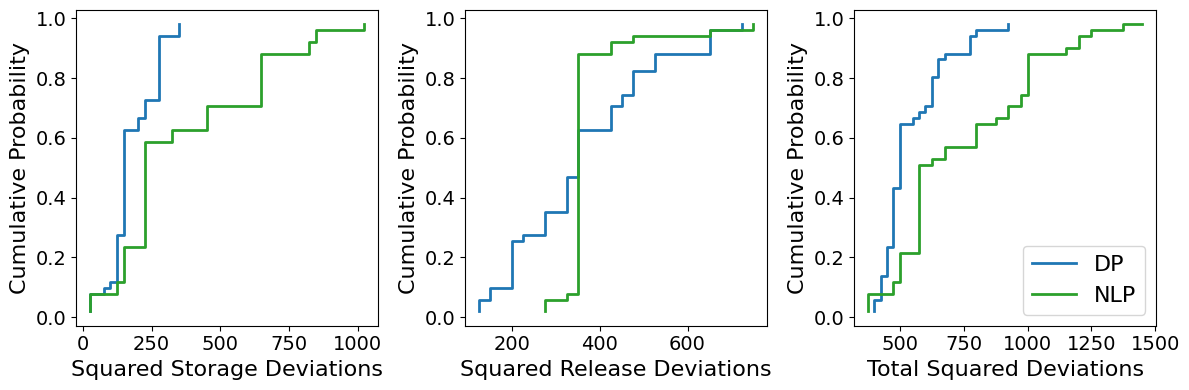

In [7]:
# cumulative probabilities
p = np.arange(1,nYears+1,1) / (nYears+1)

# plot ECDF of R, S and total deviations for each policy
fig = plt.figure(figsize=[12,4])

# make list of things to loop through for each plot
DP_costs = [DP.S_costs, DP.R_costs, DP.Total_costs]
NLP_costs = [NLP.S_costs, NLP.R_costs, NLP.Total_costs]
xlabels = ["Squared Storage Deviations", "Squared Release Deviations", "Total Squared Deviations"]

for i in range(len(DP_costs)):
  ax = fig.add_subplot(1,3,i+1)
  # step-function of sorted deviations from target for each algorithm
  l1, = ax.step(np.sort(DP_costs[i]),p,color="tab:blue",linewidth=2)
  l2, = ax.step(np.sort(NLP_costs[i]),p,color="tab:green",linewidth=2)
  ax.set_xlabel(xlabels[i], fontsize=16)
  ax.set_ylabel("Cumulative Probability", fontsize=16)
  ax.tick_params(axis="both",labelsize=14)

ax.legend([l1, l2],["DP","NLP"],fontsize=16,loc="lower right")
fig.tight_layout()
fig.show()

DP equals or outperforms NLP on the storage deviations across the whole distribution. It outperforms NLP for the lower 50\% of the release deviations distribution, but has larger deviations in the upper 50% of the distribution. Summing across the two, DP does better over all but the best ~5\% years, significantly reducing the worst total deviations. This is because of its ability to adapt decisions at each stage if the state is not what was expected due to a different inflow than what was forecast.